In [3]:
!pip install langgraph-codeact
!pip install e2b-code-interpreter

## 大语言模型的代码沙箱

In [14]:
import getpass  # 导入用于安全输入密码的模块
import os  # 导入操作系统相关的模块

# 首先，让我们下载所需的软件包并设置我们的 API 密钥：
def _set_env(key: str):
    """
    设置环境变量的函数。
    
    参数:
    key (str): 要设置的环境变量的名称。
    
    如果指定的环境变量名称在当前环境中不存在，则提示用户输入值并将其设置为该环境变量。
    """
    if key not in os.environ:  # 检查环境变量是否已存在
        os.environ[key] = getpass.getpass(f"{key}:")  # 如果不存在，提示用户输入并设置环境变量

_set_env("OPENAI_API_KEY")  # 调用函数设置 OPENAI_API_KEY 环境变量

In [17]:
import contextlib
import io
import builtins
from typing import Any, Dict, Tuple
import asyncio

async def async_eval(code: str, _locals: Dict[str, Any]) -> Tuple[str, Dict[str, Any]]:
    """
    异步环境下执行代码，但使用与原始eval函数相同的执行方式
    
    参数:
        code: 要执行的代码字符串
        _locals: 本地变量字典
        
    返回:
        tuple: (执行结果输出, 新创建的变量字典)
    """
    # 记录执行前的变量键
    original_keys = set(_locals.keys())
    
    # 创建一个Future对象，用于在事件循环中执行同步代码
    loop = asyncio.get_running_loop()
    
    def execute_code():
        try:
            with contextlib.redirect_stdout(io.StringIO()) as f:
                exec(code, builtins.__dict__, _locals)
            result = f.getvalue()
            if not result:
                result = "<代码已执行，但没有输出到stdout>"
            return result, None
        except Exception as e:
            return f"执行错误: {repr(e)}", e
    
    # 在事件循环的线程池中执行同步代码
    result, error = await loop.run_in_executor(None, execute_code)
    
    # 确定执行过程中创建的新变量
    new_keys = set(_locals.keys()) - original_keys
    new_vars = {key: _locals[key] for key in new_keys}
    
    return result, new_vars

async def eval(code: str, _locals: Dict[str, Any]) -> Tuple[str, Dict[str, Any]]:
    """
    异步版本的eval函数，可以在异步环境中使用
    
    参数:
        code: 要执行的代码字符串
        _locals: 本地变量字典
        
    返回:
        tuple: (执行结果输出, 新创建的变量字典)
    """
    return await async_eval(code, _locals)


def sync_eval(code: str, _locals: Dict[str, Any]) -> Tuple[str, Dict[str, Any]]:
    """
    同步版本的eval函数包装器，可以在非异步环境中使用
    
    参数:
        code: 要执行的代码字符串
        _locals: 本地变量字典
        
    返回:
        tuple: (执行结果输出, 新创建的变量字典)
    """
    # 获取或创建事件循环
    try:
        loop = asyncio.get_event_loop()
    except RuntimeError:
        loop = asyncio.new_event_loop()
        asyncio.set_event_loop(loop)
    
    # 运行异步函数并获取结果
    return loop.run_until_complete(async_eval(code, _locals))

## 定义你的工具
你可以使用任何你想要的工具，包括自定义工具、LangChain 工具或 MCP 工具。在这个例子中，我们定义了一些简单的数学函数。

In [6]:
import math

from langchain_core.tools import tool

def add(a: float, b: float) -> float:
    """Add two numbers together."""
    return a + b

def multiply(a: float, b: float) -> float:
    """Multiply two numbers together."""
    return a * b

def divide(a: float, b: float) -> float:
    """Divide two numbers."""
    return a / b

def subtract(a: float, b: float) -> float:
    """Subtract two numbers."""
    return a - b

def sin(a: float) -> float:
    """Take the sine of a number."""
    return math.sin(a)

def cos(a: float) -> float:
    """Take the cosine of a number."""
    return math.cos(a)

def radians(a: float) -> float:
    """Convert degrees to radians."""
    return math.radians(a)

def exponentiation(a: float, b: float) -> float:
    """Raise one number to the power of another."""
    return a**b

def sqrt(a: float) -> float:
    """Take the square root of a number."""
    return math.sqrt(a)

def ceil(a: float) -> float:
    """Round a number up to the nearest integer."""
    return math.ceil(a)

tools = [
    add,
    multiply,
    divide,
    subtract,
    sin,
    cos,
    radians,
    exponentiation,
    sqrt,
    ceil,
]

In [24]:
from langchain.chat_models import init_chat_model
from langgraph_codeact import create_codeact
from langgraph.checkpoint.memory import MemorySaver

model = init_chat_model("openai:gpt-4o")

code_act = create_codeact(model, tools, sync_eval)
agent = code_act.compile(checkpointer=MemorySaver())


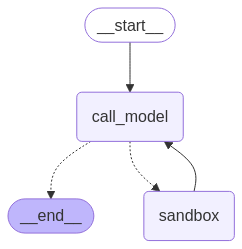

In [20]:
from IPython.display import Image

Image(agent.get_graph().draw_mermaid_png())

## 测试最终的结果

In [25]:
messages = [{
    "role": "user",
    "content": "A batter hits a baseball at 45.847 m/s at an angle of 23.474° above the horizontal. The outfielder, who starts facing the batter, picks up the baseball as it lands, then throws it back towards the batter at 24.12 m/s at an angle of 39.12 degrees. How far is the baseball from where the batter originally hit it? Assume zero air resistance."
}]
for typ, chunk in agent.stream(
    {"messages": messages},
    stream_mode=["values", "messages"],
    config={"configurable": {"thread_id": 1}},
):
    if typ == "messages":
        print(chunk[0].content, end="")
    elif typ == "values":
        print("\n\n---answer---\n\n", chunk)



---answer---

 {'messages': [HumanMessage(content='A batter hits a baseball at 45.847 m/s at an angle of 23.474° above the horizontal. The outfielder, who starts facing the batter, picks up the baseball as it lands, then throws it back towards the batter at 24.12 m/s at an angle of 39.12 degrees. How far is the baseball from where the batter originally hit it? Assume zero air resistance.', additional_kwargs={}, response_metadata={}, id='1e15f42b-93d0-43e1-ba72-db5be7c3e109')]}
To solve this problem, we'll calculate the horizontal distances covered during the baseball's initial journey and its return journey to the batter.

### Steps:
1. Breakdown the initial launch of the baseball into horizontal and vertical components.
2. Calculate the time of flight of the baseball using the vertical motion.
3. Compute the horizontal distance covered during the baseball's flight to the outfielder.
4. Repeat the process for the return throw by the outfielder.
5. Sum the two horizontal distances to 